In [31]:
from typing import TypedDict,List
import re

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI,OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph,START,END
from pydantic import BaseModel
from dotenv import load_dotenv

from langchain_community.tools.tavily_search import TavilySearchResults

load_dotenv()

True

In [32]:
docs=(
    PyPDFLoader("../apjspeech.pdf").load()
    +PyPDFLoader("llms.pdf").load()
)

In [33]:
chunks=RecursiveCharacterTextSplitter(chunk_size=900,chunk_overlap=150).split_documents(docs)

for d in chunks:
    d.page_content =d.page_content.encode("utf-8","ignore").decode("utf-8","ignore")

In [34]:
embeddings=OpenAIEmbeddings(model="text-embedding-3-large")
vectore_store=FAISS.from_documents(chunks,embeddings)
retriever=vectore_store.as_retriever(search_type="similarity",search_kwargs={"k":4})

In [35]:
llm=ChatOpenAI(model="gpt-4o-mini",temperature=0)

In [36]:
UPPER_TH=0.7
LOWER_TH=0.3

In [37]:
class State(TypedDict):
    question:str
    docs:List[Document]

    good_docs:List[Document]
    verdict:str
    reason:str

    strips:List[str]
    kept_strips:List[str]
    refined_context:str

    web_docs:List[Document]
    web_query:str

    answer:str

In [38]:
def retrieve(state:State)->State:
    q=state["question"]
    return {"docs":retriever.invoke(q)}

In [39]:
class DocEvalScore(BaseModel):
    score:float
    reason:str

doc_eval_prompt=ChatPromptTemplate.from_messages(
    [
        ("system","You are a strict retrieval evaluator for RAG.\n You will be given ONE retrieved chunk and a question.\n Return a relevance score in [0.0 ,1.0].\n - 1.0: chunk alone is sufficient to answer fully/mostly\n.- 0.0 :chunk is irrelevant\n Be conservative with high scores.\n Also return a short reason.\n Output JSON only."),
        ("human","Question {question}\n\n Chunk:\n {chunk}"),
    ]
)

doc_eval_chain=doc_eval_prompt | llm.with_structured_output(DocEvalScore)

def eval_each_doc_model(state:State)->State:
    q=state["question"]

    scores:List[float]=[]
    reasons:List[str]=[]
    good:List[Document]=[]

    for d in state["docs"]:
        out=doc_eval_chain.invoke({"question":q,"chunk":d.page_content})
        scores.append(out.score)
        reasons.append(out.reason)

        if out.score>LOWER_TH:
            good.append(d)
        
    if any(s > UPPER_TH for s in scores):
        return {
            "good_docs":good,
            "verdict":"CORRECT",
            "reason":f"At least one retrieved chunk scored >{UPPER_TH}"
        }
    
    if len(scores)>0 and all(s < LOWER_TH for s in scores):
        why="No chunk was sufficient."
        return {
            "good_docs":[],
            "verdict":"INCORRECT",
            "reason":f"All retrieved chunks scored <{LOWER_TH}.{why}"
        }
    
    why="Mixed relevance signals."
    return {
            "good_docs":good,
            "verdict":"AMBIGUOUS",
            "reason":f"No chunk scored > {UPPER_TH},but not all were < {LOWER_TH}.{why}"
        }


In [40]:
def decompose_to_sentences(text:str)->List[str]:
    text=re.sub(r"\s+"," ",text).strip()
    sentences=re.split(r"(?=[.?])\s+",text)
    return [s.strip() for s in sentences if len(s.strip()) > 20]

class KeepOrDrop(BaseModel):
    keep:bool

Filter_prompt=ChatPromptTemplate.from_messages(
    [
        ("system","You are a strict relevance filter.\n Return keep=true only if the sentence directly helps answer the question.\n use only sentence. output json only."),
        ("human","Question: {question} \n\n Sentence:\n {sentence}"),
    ]
)

filter_chain=Filter_prompt| llm.with_structured_output(KeepOrDrop)


def refine(state:State)->State:
    q=state["question"]

    if state["verdict"]=="CORRECT":
        context="\n\n".join(d.page_content for d in state["good_docs"]).strip()
    else:
        context="\n\n".join(d.page_content for d in state["web_docs"]).strip()

    strips=decompose_to_sentences(context)

    kept:List[str]=[]

    for s in strips:
        if filter_chain.invoke({"question":q,"sentence":s}).keep:
            kept.append(s)

    refined_context="\n".join(kept).strip()

    return {
        "strips":strips,
        "kept_strips":kept,
        "refined_context":refined_context
    }

In [41]:
class WebQuery(BaseModel):
    query:str

rewrite_prompt=ChatPromptTemplate.from_messages(
    [
        ("system","Rewrite the user question into a web search composed of keywords.\n Rules:\n -Keep it short (6-14 words).\n - If the question implies recency (e.g., recent/latest/last week/ last month), add a constraint like(last).\n - Do Not answer the question.\n Return JSON with a single key:query"),
        ("human","Question:{question}")
    ]
)


rewrite_chain=rewrite_prompt | llm.with_structured_output(WebQuery)

def rewrite_query_node(state:State)->State:
    out=rewrite_chain.invoke({"question":state["question"]})
    return {"web_query":out.query}

In [52]:
tavily=TavilySearchResults(max_results=5)

def web_search_node(state:State)->State:
    q = state.get("web_query") or state["question"]
    results=tavily.invoke({"query":q})
    web_docs=[]

    for r in results or []:
        title=r.get("title","")
        url=r.get("url","")
        content=r.get("content","") or r.get("snippet","")

        text=f"TITLE: {title}\n URL :{url}\n CONTENT:\n{content}"

        web_docs.append(Document(page_content=text,metadata={"url":url,"title":title}))

    return {"web_docs":web_docs}


In [53]:
answe_prompt=ChatPromptTemplate.from_messages(
    [
        ("system","You are a helpful ML tutor. Answer only using the provided refined bullts.\n If the bullets are empty or insufficient, say: 'I dont't Know on the provided docs"),
        ("human","Question: {question}\n\n Refined context:\n {refined_context}")
    ]
)

def generate(state:State)->State:
    out=(answe_prompt|llm).invoke({"question":state["question"],"refined_context":state['refined_context']})
    return {"answer":out.content}

In [54]:

def ambiguous_node(state:State)->State:
    return {"answer":f"Ambiguous: {state['reason']}"}

def route_after_eval(state:State)->State:
    if state["verdict"]=="CORRECT":
        return "refine"
    elif state["verdict"]=="INCORRECT":
        return "web_search"
    else:
        return "ambiguous"

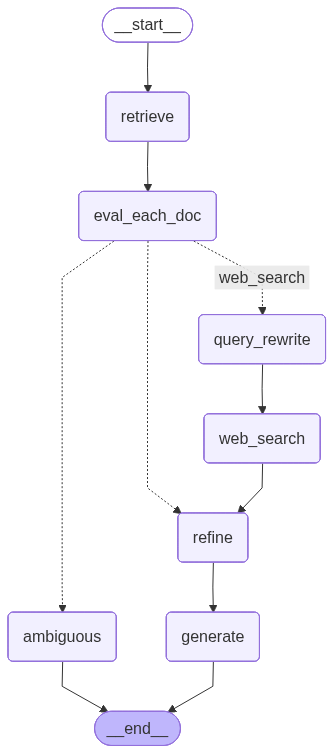

In [57]:
g=StateGraph(State)
g.add_node("retrieve",retrieve)
g.add_node("refine",refine)
g.add_node("generate",generate)
g.add_node("eval_each_doc",eval_each_doc_model)
g.add_node("ambiguous",ambiguous_node)
g.add_node("web_search",web_search_node)
g.add_node("query_rewrite",rewrite_query_node)

g.add_edge(START,"retrieve")
g.add_edge("retrieve","eval_each_doc")

g.add_conditional_edges(
    "eval_each_doc",route_after_eval,
    {"refine":"refine","web_search":"query_rewrite","ambiguous":"ambiguous"}
)
g.add_edge("query_rewrite","web_search")
g.add_edge("web_search","refine")
g.add_edge("refine","generate")
g.add_edge("generate",END)
g.add_edge("ambiguous",END)

app=g.compile()

app


In [58]:
res=app.invoke({
    "question":"AI submit in india 2026",
    "docs":[],
    "good_docs":[],
    "verdict":"",
    "reason":"",
    "strips":[],
    "kept_strings":[],
    "refined_context":[],
    "web_query":"",
    "web_docs":[],
    "answer":""
})
print("VERDICT",res["verdict"])
print("REASON",res["reason"])
print("\nOUTPUT:\n",res["answer"])

VERDICT INCORRECT
REASON All retrieved chunks scored <0.3.No chunk was sufficient.

OUTPUT:
 The India AI Impact Summit is scheduled to be held in New Delhi, India, from February 19–20, 2026. There is a call for submissions for the Global South Showcase (GSS) with a submission deadline of November 30, 2025. Additionally, the AI and Social Good track for IJCAI 2026 has an abstract submission deadline of January 12, 2026, and a full paper submission deadline of January 19, 2026. The International Conference on AI Engineering and Innovation (AIEI 2026) will take place from March 26–28, 2026, at NIT Jamshedpur, India.
